In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal

In [3]:
def ramp(x, per=4):
    return ((x%per < per/2)*(x%per) + (x%per >= per/2)*(-x%per))/2

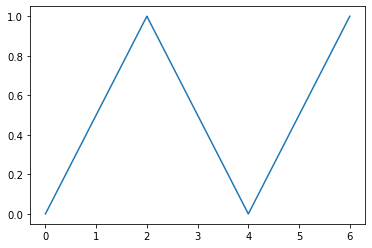

In [4]:
x = np.linspace(0,6,10_000)
y = ramp(x, per=4)
plt.plot(x,y)

In [5]:
def loren(x, cent=0.0, width=1.0):
    return 1.0/(1.0 + (x-cent)**2/width**2)

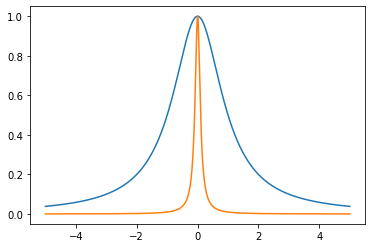

In [6]:
x = np.linspace(-5,5,10_000)
plt.plot(x, loren(x, width=1.0))
plt.plot(x, loren(x, width=0.1))

In [7]:
def absorp(nu, optical_depth=1.0, cent=1.0, width=0.2):
    return np.exp(-optical_depth*loren(nu, cent=cent, width=width))

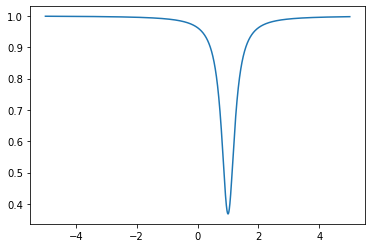

In [8]:
plt.plot(x, absorp(x, cent=1))

In [9]:
OMEGA_MOD = 5000 * 2*np.pi
MOD_DEPTH = 0.01
I_DEPTH = 1.0
INTENSITY_PHASE = 0.1

t=np.linspace(0,2,300_000)
nu = MOD_DEPTH * np.sin(OMEGA_MOD*t) + ramp(t)   # Laser optical frequency detuning
li = 1 + I_DEPTH * nu                            # Laser intensity

lr = absorp(nu, cent=0.5, width=0.02, optical_depth=0.01)*li + np.random.random(len(nu))*0.0

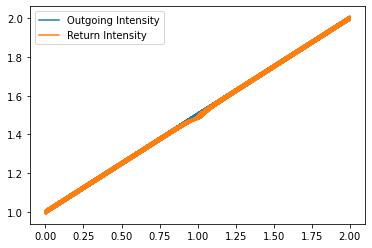

In [10]:
plt.plot(t, li, label='Outgoing Intensity')
plt.plot(t, lr, label='Return Intensity')
plt.legend()

In [16]:
def lowPassFilter(y,freq=0.0002,order=2):
    transferNumerator, transferDenominator = scipy.signal.butter(order,freq,'lowpass')
    y = scipy.signal.lfilter(transferNumerator,transferDenominator,y)
    return y

def lock_in(y, ref_phase, filter_freq=0.0002):
    i_1f = np.sin(ref_phase)
    q_1f = np.cos(ref_phase)
    i_2f = np.sin(2*ref_phase)
    q_2f = np.cos(2*ref_phase)
    
    out_data = (lowPassFilter(y*i_1f,freq=filter_freq),
                lowPassFilter(y*q_1f,freq=filter_freq),
                lowPassFilter(y*i_2f,freq=filter_freq),
                lowPassFilter(y*q_2f,freq=filter_freq))
    return out_data

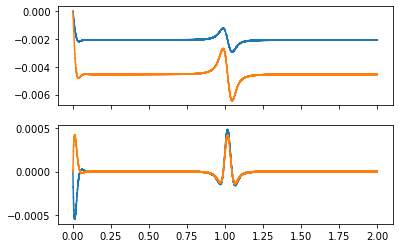

In [17]:
i_1f, q_1f, i_2f, q_2f = lock_in(lr, OMEGA_MOD*t + 2)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(t, i_1f)
ax1.plot(t, q_1f)
ax2.plot(t, i_2f)
ax2.plot(t, q_2f)

In [242]:
def modCurve(mod_omega, mod_depth, mod_depth_2s, mod_depth_2c, i_depth, i_depth_2, i_depth_3, i_phase, line_width, line_depth, demod_lpf, demod_phase, sweep_rate):
    N = 300_000
    
    t=np.linspace(-1/sweep_rate,1/sweep_rate,N)
    nu = mod_depth * np.sin(mod_omega*t) + mod_depth_2s * np.sin(2*mod_omega*t) + mod_depth_2c * np.cos(2*mod_omega*t) + t*sweep_rate   # Laser optical frequency detuning
    I=mod_depth * np.sin(mod_omega*t + i_phase) + t*sweep_rate #Laser Current
    li = 1 + i_depth * (I) + i_depth_2 * (I)**2 + i_depth_3 * (I)**3  # Laser intensity

    lr = li*absorp(nu, cent=0.0, width=line_width, optical_depth=line_depth) + np.random.random(len(nu))*0.0
    
    i_1f, q_1f, i_2f, q_2f = lock_in(lr, mod_omega*t + demod_phase, filter_freq=demod_lpf)
    
    #Trim to remove filter artifacts
    TRIM_FACTOR = 8
    t = t[N//TRIM_FACTOR:-N//TRIM_FACTOR]
    i_1f = i_1f[N//TRIM_FACTOR:-N//TRIM_FACTOR]
    q_1f = q_1f[N//TRIM_FACTOR:-N//TRIM_FACTOR]
    i_2f = i_2f[N//TRIM_FACTOR:-N//TRIM_FACTOR]
    q_2f = q_2f[N//TRIM_FACTOR:-N//TRIM_FACTOR]
    
    return t, i_1f, q_1f, i_2f, q_2f

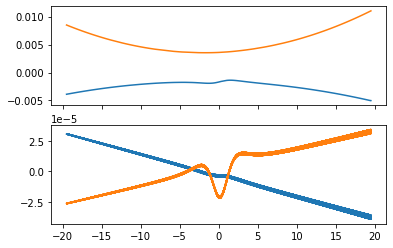

In [264]:
lir=    modCurve(8000*2*np.pi, # Mod Freq (rad/s)
                 0.01,         # Mod Depth
                 0.00,         # Mod Depth (2nd order inphase)
                 0.00,         # Mod Depth (2nd order quad)
                 0.8,          # I Depth,
                 0.2,          # I Depth 2nd order
                 0.8,          # I Depth 3rd order
                 2.0,          # I Phase
                 0.1,         # Line Width
                 0.01,         # Line Depth
                 0.0005,       # Demod filter Freq,
                 0,          # Demod phase
                 1/26)          # Sweep Rate

fig, (ax1,ax2)  = plt.subplots(2,sharex=True)
ax1.plot(lir[0], lir[1])
ax1.plot(lir[0], lir[2])
ax2.plot(lir[0], lir[3])
ax2.plot(lir[0], lir[4])